In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import gc
from tqdm.notebook import tqdm
from collections import deque

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, GPT2LMHeadModel, set_seed

from src.config import Config
from src.dataset import SBICDataset

CONFIG:Config = Config()
set_seed(CONFIG.seed)

2023-09-27 19:40:16.803529: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 19:40:17.472440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = pd.read_pickle(CONFIG.dataset.train_data_raw)
df.head()

,whoTarget,intentYN,sexYN,offensiveYN,speakerMinorityYN,post,targetMinority,targetCategory,targetStereotype,dataSource
0,0.0,1.0,0.0,1.0,0.0,RT @_LexC__: I'm convinced that some of y'all ...,,,,t/davidson
1,0.0,1.0,0.0,1.0,0.0,RT @_LexC__: I'm convinced that some of y'all ...,,,,t/davidson
2,0.0,0.0,0.0,1.0,0.0,RT @_LexC__: I'm convinced that some of y'all ...,,,,t/davidson
3,1.0,1.0,0.0,1.0,0.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,all stupid,t/davidson
4,1.0,1.0,0.0,1.0,0.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,are not people but apes.,t/davidson


In [4]:
tokenizer = AutoTokenizer.from_pretrained('gpt2', padding_side="left")
model = GPT2LMHeadModel.from_pretrained('gpt2')

tokenizer.add_special_tokens(CONFIG.train_params.special_tokens)
print("List of all special token and its token_id:")
print(" -", tokenizer.all_special_tokens)
print(" -",tokenizer(tokenizer.all_special_tokens)["input_ids"])
print("Model vocab size pre resize:", model.config.vocab_size)
model.resize_token_embeddings(len(tokenizer))
print("Model vocab size post resize:", model.config.vocab_size)
model.config.pad_token_id = tokenizer.pad_token_id
model.config.sep_token_id = tokenizer.sep_token_id
print("Model pad token:", model.config.pad_token_id)
print("Model sep token:", model.config.sep_token_id)

model.generation_config.max_new_tokens=100

List of all special token and its token_id:
 - ['<|endoftext|>', '[SEP]', '[PAD]', '[offY]', '[offN]', '[sexY]', '[sexN]', '[intY]', '[intN]', '[grpY]', '[grpN]', '[ingrpN]', '[ingrpY]']
 - [[50256], [50258], [50257], [50259], [50260], [50261], [50262], [50263], [50264], [50265], [50266], [50267], [50268]]
Model vocab size pre resize: 50257
Model vocab size post resize: 50269
Model pad token: 50257
Model sep token: 50258


In [5]:
train_data = pd.read_pickle(CONFIG.dataset.train_data_raw).to_numpy()[4:5]
# val_data = pd.read_pickle(CONFIG.dataset.val_data_raw).to_numpy()[:100]

train_dataset = SBICDataset(train_data, tokenizer, CONFIG.utils.class_label_encoder, max_sequence_length=256)
# val_dataset = SBICDataset(val_data, tokenizer, CONFIG.utils.class_label_encoder)

train_loader = DataLoader(train_dataset, batch_size=1, drop_last=False, shuffle=True, pin_memory=True)
# val_loader   = DataLoader(val_dataset,   batch_size=CONFIG.train_params.batch_size, drop_last=False, shuffle=True, pin_memory=True)

In [6]:
# model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to(CONFIG.train_params.device)

optimizer = AdamW(model.parameters(), lr=3e-5)

total_loss = 0
loss_epochs = deque(maxlen=200)

for epoch in range(200):
    model.train()
    epoch_train_loss = 0.0
    optimizer.zero_grad()
    for n_iter, batch in enumerate(train_loader):
    # for n_iter, batch in enumerate(tqdm(train_loader, total=len(train_loader))):
        inputs = {k: v.to(CONFIG.train_params.device) for k, v in batch.items()}
        
        model.zero_grad()
            
        # Forward pass
        outputs = model(**inputs)
        loss, logit = outputs[:2]

        total_loss += loss.item()

        if n_iter % 10 == 0:
            print(f"Epoch {epoch}: loss = {loss.item()} iteration n°{n_iter+1}")
        
        # Backward pass
        loss.backward()
        loss_epochs.append(loss.item())

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad()
                
        # gc.collect()

    avg_epoch_loss = total_loss / len(train_loader)

gc.collect
torch.cuda.empty_cache()

Epoch 0: loss = 16.476198196411133 iteration n°1
Epoch 1: loss = 13.789762496948242 iteration n°1
Epoch 2: loss = 13.076373100280762 iteration n°1
Epoch 3: loss = 8.463748931884766 iteration n°1
Epoch 4: loss = 21.347997665405273 iteration n°1
Epoch 5: loss = 31.759178161621094 iteration n°1
Epoch 6: loss = 12.853395462036133 iteration n°1
Epoch 7: loss = 8.746526718139648 iteration n°1
Epoch 8: loss = 10.741125106811523 iteration n°1
Epoch 9: loss = 13.581804275512695 iteration n°1
Epoch 10: loss = 7.8166422843933105 iteration n°1
Epoch 11: loss = 8.982293128967285 iteration n°1
Epoch 12: loss = 6.716204643249512 iteration n°1
Epoch 13: loss = 9.906657218933105 iteration n°1
Epoch 14: loss = 9.838460922241211 iteration n°1
Epoch 15: loss = 6.453627586364746 iteration n°1
Epoch 16: loss = 9.579803466796875 iteration n°1
Epoch 17: loss = 5.560927867889404 iteration n°1
Epoch 18: loss = 21.55367088317871 iteration n°1
Epoch 19: loss = 5.13635778427124 iteration n°1
Epoch 20: loss = 8.756

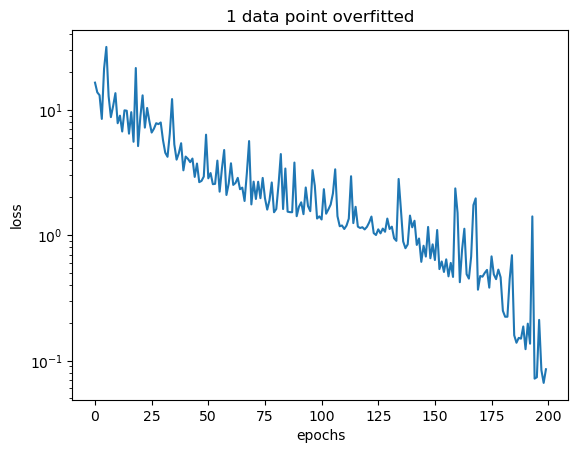

In [7]:
import matplotlib.pyplot as plt

plt.semilogy(loss_epochs)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("1 data point overfitted")
plt.show()

In [8]:
model.eval()

with torch.no_grad():
    for n_iter, batch in enumerate(train_loader):
        inputs = {k: v.to(CONFIG.train_params.device) for k, v in batch.items()}
        text = tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=False).replace("[PAD]", "")

        # Forward pass
        outputs = model(input_ids=inputs["input_ids"],
                        attention_mask=inputs["attention_mask"])
        
        logits = outputs.logits[0, -1, :]
        # softmax = torch.softmax(logits, axis=-1)
        argmax = torch.argmax(logits, axis=-1)
        print(text, "->", tokenizer.decode(argmax), "")

        # print(len(outputs[1]))

        # decoded_output = tokenizer.decode(outputs, skip_special_tokens=False)
        # decoded_output = decoded_output.replace("[PAD]", "")
        # print(decoded_output)

RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot.[SEP] -> [SEP] 


In [9]:
model.eval()

with torch.no_grad():
    for n_iter, batch in enumerate(train_loader):
        inputs = {k: v.to(CONFIG.train_params.device) for k, v in batch.items()}
        # text = tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=False).replace("[PAD]", "")

        outputs = model.generate(inputs["input_ids"], max_new_tokens=20)

        decoded_output = tokenizer.decode(outputs.cpu().numpy()[0], skip_special_tokens=False)
        decoded_output = decoded_output.replace("[PAD]", "")
        print(decoded_output)

RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot.[SEP][sexN][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][SEP][offY][SEP][offY][offY][offY][offY][offY][offY][offY]


/home/matteo/miniconda3/envs/nlp/lib/python3.11/site-packages/transformers/generation/utils.py:1255: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
